### Metro Nashville Emergency Communications

#### Snickers: Hypothesis: tie between economic status in NW region of Davidson and number of calls received, specifically lack of calls. Very few calls from northwest region of Davidson. Correlate income per zipcode with calls for each storm.

Snickers: North nashville, compare calls/dispatches to full county

#### Timeline of each storm/ Beginning and end of the event
Tornado calls: 3/3/2020 12:34am-4:58am

Tornado cad: 12:36am-4:57am

Derecho calls: 5/3/2020 4:30pm- 5/4/2020 12:29am

Derecho cad: 4:31pm-12:29am

In [20]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import folium
from folium import plugins
import ipywidgets
import numpy as np

### Reading in data

In [2]:
derecho_calls=pd.read_csv("../data/911_Phone Calls_Derecho_050320 050420.csv")
tornado_calls=pd.read_csv("../data/911_Phone_Calls_Tornado_030320.csv")
derecho_cad=pd.read_csv("../data/Computer Aided Dispatch Data_Derecho Incidents 050320-050420.csv", skiprows=3)
tornado_cad=pd.read_csv("../data/Computer Aided Dispatch Data_Tornado Incidents 030320.csv", skiprows=3)
sirens = pd.read_csv('../data/Tornado_Siren_Locations.csv')
dispatch = pd.read_csv('../data/dispatch.csv')
zipcodes = gpd.read_file('../data/zipcodes.geojson')
print(zipcodes.crs)

epsg:4326


### Renaming and setting up columns

In [3]:
tornado_calls.columns = ['datetime', 'calltype','lat','lng','address']
derecho_cad.columns = ['datetime', 'calltype','lat','lng','alarm']
tornado_cad.columns = ['datetime', 'calltype','lat','lng','alarm']
derecho_calls.columns = ['datetime', 'calltype','lat','lng','address']
zipcodes = zipcodes[['zip', 'po_name', 'geometry']]
dispatch=dispatch[[ 'tencode', 'lat', 'lng', 'call_date','call_time']]

In [4]:
sirens[["lat", "lng"]]= sirens.pop("Location").str.split(", ", n = 1, expand = True)
sirens['lat']= sirens['lat'].str[1:]
sirens['lng'] = sirens['lng'].str[:-1]
sirens=sirens[["Site Name", "Zip","lat","lng"]]
sirens.head(20)

,Site Name,Zip,lat,lng
0,Ezell Road Park,37211,36.090944,-86.686028
1,Sevier Park,37204,36.118861,-86.787889
2,Fannie May Dees Park,37212,36.136167,-86.8055
3,Paragon Mills Park,37211,36.235417,-86.772778
4,Jere Baxter Alternative,37216,36.212694,-86.732917
5,Glenview Elementary,37217,36.127278,-86.706694
6,Ted Rhodes Golf Course,37228,36.194194,-86.817639
7,Hartman Park,37218,36.210306,-86.82425
8,Cedar Hill Park,37115,36.269722,-86.748139
9,Richland Park,37209,36.151806,-86.845


### Creating geometry column for dfs

In [5]:
derecho_calls['geometry'] = derecho_calls.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
tornado_calls['geometry'] = tornado_calls.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
tornado_cad['geometry'] = tornado_cad.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
derecho_cad['geometry'] = derecho_cad.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
dispatch['geometry'] = dispatch.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
sirens['geometry'] = sirens.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)

In [6]:
zipcodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
tornado_calls_geo = gpd.GeoDataFrame(tornado_calls, 
                           crs = zipcodes.crs, 
                           geometry = tornado_calls['geometry'])
type(tornado_calls_geo)
derecho_calls_geo = gpd.GeoDataFrame(derecho_calls, 
                           crs = zipcodes.crs, 
                           geometry = derecho_calls['geometry'])
type(derecho_calls_geo)
tornado_cad_geo = gpd.GeoDataFrame(tornado_cad, 
                           crs = zipcodes.crs, 
                           geometry = tornado_cad['geometry'])
type(tornado_cad_geo)
derecho_cad_geo = gpd.GeoDataFrame(derecho_cad, 
                           crs = zipcodes.crs, 
                           geometry = derecho_cad['geometry'])
type(derecho_cad_geo)
dispatch_geo = gpd.GeoDataFrame(dispatch, 
                           crs = zipcodes.crs, 
                           geometry = dispatch['geometry'])
type(dispatch_geo)
sirens_geo = gpd.GeoDataFrame(sirens, 
                           crs = zipcodes.crs, 
                           geometry = dispatch['geometry'])
type(sirens_geo)

geopandas.geodataframe.GeoDataFrame

### Joining dfs

In [8]:
tornado_calls_zip = gpd.sjoin(tornado_calls_geo, zipcodes, op = 'within')
tornado_calls_zip=tornado_calls_zip.reset_index(drop = True)
tornado_cad_zip = gpd.sjoin(tornado_cad_geo, zipcodes, op = 'within')
tornado_cad_zip=tornado_cad_zip.reset_index(drop = True)
derecho_calls_zip = gpd.sjoin(derecho_calls_geo, zipcodes, op = 'within')
derecho_calls_zip=derecho_calls_zip.reset_index(drop = True)
derecho_cad_zip = gpd.sjoin(derecho_cad_geo, zipcodes, op = 'within')
derecho_cad_zip=derecho_cad_zip.reset_index(drop = True)
dispatch_zip = gpd.sjoin(dispatch_geo, zipcodes, op = 'within')
dispatch_zip=dispatch_zip.reset_index(drop = True)

### Drilling down to NW Nash

In [9]:
poly_zip=zipcodes[zipcodes['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
poly_zip=poly_zip.reset_index(drop = True)
tcalls_in_nw = tornado_calls_zip[tornado_calls_zip['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
tcalls_in_nw=tcalls_in_nw.reset_index(drop = True)
tcad_in_nw = tornado_cad_zip[tornado_cad_zip['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
tcad_in_nw=tcad_in_nw.reset_index(drop = True)
dcalls_in_nw = derecho_calls_zip[derecho_calls_zip['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
dcalls_in_nw=dcalls_in_nw.reset_index(drop = True)
dcad_in_nw = derecho_cad_zip[derecho_cad_zip['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
dcad_in_nw=dcad_in_nw.reset_index(drop = True)
sirens_nw=sirens[sirens['Zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]
dispatch_nw=dispatch_zip[dispatch_zip['zip'].isin(['37207', '37072', '37189', '37218','37015','37080'])]

### Separating storms from dispatch data

In [ ]:
dispatch_tornado=dispatch_zip[dispatch_zip['call_date'].isin(['03/03/2020'])]
dispatch_tornado=dispatch_tornado.reset_index(drop = True)
dispatch_derecho=dispatch_zip[dispatch_zip['call_date'].isin(['05/03/2020','05,04,2020'])]
dispatch_derecho=dispatch_derecho.reset_index(drop = True)

In [ ]:
nashville = (36.16784, -86.77816)

nash_map = folium.Map(location = nashville, zoom_start = 10)

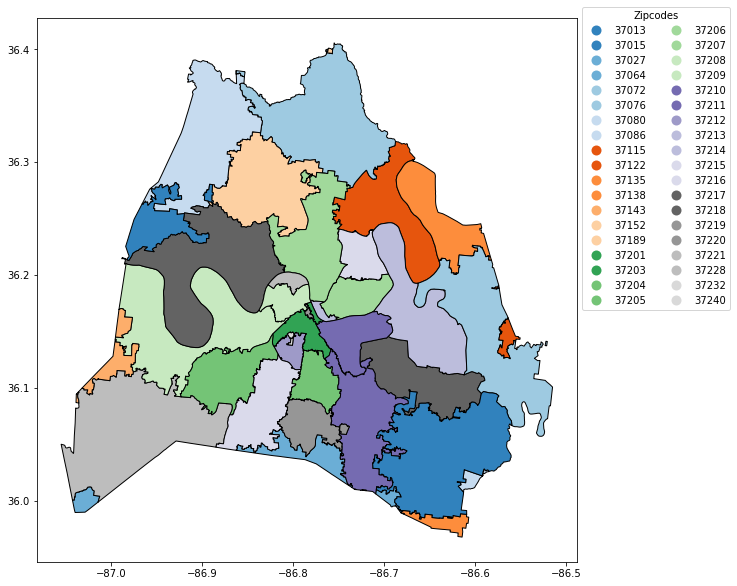

In [17]:
leg_kwds = {'title': 'Zipcodes', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 2}

zipcodes.plot(column = 'zip', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'tab20c')
plt.show()

In [ ]:
cluster_map_nw = folium.Map(location =  nashville, zoom_start = 12)

marker_cluster = MarkerCluster().add_to(cluster_map_nw)

folium.GeoJson(poly_zip).add_to(cluster_map_nw)

for row_index, row_values in dcalls_in_nw.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['address'])
    icon=folium.Icon(color="red",icon="phone", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
cluster_map_nw.save('../maps/clusternw.html')

cluster_map_nw  